# 0 Summary of Data: Aim of Notebook
This notebook aims to summarise the EDA portion of the project, highlight necessary differences, and process any and all data cleaning before the actual analysis commences. We will be looking at the data through the following workflow:

1. **Summarise differences between train and test sets**, and any transformations that need to be taken into account when processing the train or test sets.

2. Looking into **missing data**, **classification considerations for features**, as well as **treatment for each field**. In this section, we will also look into qualitative reasons for including or excluding some fields, as well as how data will need to be treated before any regression analysis can commence.

3. [EDA] Look at **inter-correlation of existing data**. Generally, if features are highly correlated, including both would be counter-productive to the effectiveness of our prediction model. Conversely, some uncorrelated data could also be considered noise that would only confuse our model. These will also need to be removed.

4. Lastly, a brief look at the train set and Sales Price correlation.

In [1]:
# Basic Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

In [2]:
# Get url data
import requests

## 1 Dataset Summaries

In [3]:
train_df = pd.read_csv('datasets/train.csv')
test_df = pd.read_csv('datasets/test.csv')

In [4]:
# Check rows/columns, and the types of data in the set
print('Train Dataset:')
print(train_df.shape)
print(f'object cols:{train_df.select_dtypes(object).shape[1]}')
print(f'int cols:{train_df.select_dtypes(int).shape[1]}')
print(f'float cols:{train_df.select_dtypes(float).shape[1]}')
print('\n')
print('Test Dataset:')
print(test_df.shape)
print(f'object cols:{test_df.select_dtypes(object).shape[1]}')
print(f'int cols:{test_df.select_dtypes(int).shape[1]}')
print(f'float cols:{test_df.select_dtypes(float).shape[1]}')

Train Dataset:
(2051, 81)
object cols:42
int cols:28
float cols:11


Test Dataset:
(878, 80)
object cols:42
int cols:35
float cols:3


Summary of differences between Train and Test sets:
1. Difference number of columns (should be SalesPrice)
2. Same number of object columns
3. Float/int columns different in number (8 float columns are int in test set - in consequential though)

### 1.1 Feature analysis between Train and Test sets

In [5]:
# Summarising string data columns, and if there is categorical data in the test set not in the train set
dict_test_msng = {}
for k in test_df.select_dtypes(object).columns:
    tmp = [i for i in test_df.loc[:,k].unique()
           if i not in train_df.loc[:,k].unique()]
    if (tmp != []) or (tmp != [np.nan]):
        dict_test_msng[k] = tmp

In [6]:
# Creating a dataframe to display comparison data
feat_summ = pd.DataFrame(index = train_df.columns, columns = ['train_df','test_df'])
feat_summ['train_df'] = [True if i in train_df.columns else False for i in feat_summ.index]
feat_summ['test_df'] = [True if i in test_df.columns else False for i in feat_summ.index]
feat_summ['train_null'] = train_df.isnull().sum()
feat_summ['test_null'] = test_df.isnull().sum()
feat_summ['train_null%'] = round(feat_summ['train_null']/train_df.shape[0],4) * 100
feat_summ['test_null%'] = round(feat_summ['test_null']/test_df.shape[0],4) * 100

for i in feat_summ.index:
    feat_summ.loc[i,'train_dtype'] = dict(zip(train_df.dtypes.index,train_df.dtypes[:]))[i]
    try: feat_summ.loc[i,'test_dtype'] = dict(zip(test_df.dtypes.index,test_df.dtypes[:]))[i]
    except: feat_summ.loc[i,'test_dtype'] = np.nan
    try: feat_summ.loc[i,'ms_str'] = dict_test_msng[i] # Documenting nominal data missing from test set
    except: feat_summ.loc[i,'ms_str'] = np.nan

feat_summ.head()

,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str
Id,True,True,0,0.0,0.00,0.00,int64,int64,NaN
PID,True,True,0,0.0,0.00,0.00,int64,int64,NaN
MS SubClass,True,True,0,0.0,0.00,0.00,int64,int64,NaN
MS Zoning,True,True,0,0.0,0.00,0.00,object,object,NaN
Lot Frontage,True,True,330,160.0,16.09,18.22,float64,float64,NaN


In [7]:
# Just confirming missing field from test set
print('Missing from test set:')
feat_summ[feat_summ['test_df'] == False]

Missing from test set:


,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str
SalePrice,True,False,0,NaN,0.0,NaN,int64,NaN,NaN


In [8]:
# Streamline repeatable function for data report
feat_summ[feat_summ['train_dtype'] != feat_summ['test_dtype']]

,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str
BsmtFin SF 1,True,True,1,0.0,0.05,0.0,float64,int64,NaN
BsmtFin SF 2,True,True,1,0.0,0.05,0.0,float64,int64,NaN
Bsmt Unf SF,True,True,1,0.0,0.05,0.0,float64,int64,NaN
Total Bsmt SF,True,True,1,0.0,0.05,0.0,float64,int64,NaN
Bsmt Full Bath,True,True,2,0.0,0.10,0.0,float64,int64,NaN
Bsmt Half Bath,True,True,2,0.0,0.10,0.0,float64,int64,NaN
Garage Cars,True,True,1,0.0,0.05,0.0,float64,int64,NaN
Garage Area,True,True,1,0.0,0.05,0.0,float64,int64,NaN
SalePrice,True,False,0,NaN,0.00,NaN,int64,NaN,NaN


**Missing from test set:**
1. SalePrice (y-vector variable)


**Misaligned columns (displaying train --> test):**
1. BsmtFin SF 1 (float --> int)
2. BsmtFin SF 2 (float --> int)
3. Bst Unf SF (float --> int)
4. Total Bsmt SF (float --> int)
5. Bsmt Full Bath (float --> int)
6. Bsmt Half Bath (float --> int)
7. Garage Cars (float --> int)
8. Garage Area (float --> int)

_sidenote: float/int are not much of a concern since they are both numerical data types_

### 1.2 Missing Data

In [9]:
# One feature that has a null value in test set and not train set
# Treatment can be lumped with 
feat_summ[(feat_summ['train_null'] == 0) & (feat_summ['test_null'] > 0)]

,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str
Electrical,True,True,0,1.0,0.0,0.11,object,object,[nan]


In [10]:
# Features that have null values in train set and not test set
# These features can be imputed without much issue or concern
# Bonus is that all these fields have relatively low null counts - no potential macro impacts to analysis
print(feat_summ[(feat_summ['train_null'] > 0) & (feat_summ['test_null'] == 0)].shape)
feat_summ[(feat_summ['train_null'] > 0) & (feat_summ['test_null'] == 0)]

(8, 9)


,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str
BsmtFin SF 1,True,True,1,0.0,0.05,0.0,float64,int64,NaN
BsmtFin SF 2,True,True,1,0.0,0.05,0.0,float64,int64,NaN
Bsmt Unf SF,True,True,1,0.0,0.05,0.0,float64,int64,NaN
Total Bsmt SF,True,True,1,0.0,0.05,0.0,float64,int64,NaN
Bsmt Full Bath,True,True,2,0.0,0.10,0.0,float64,int64,NaN
Bsmt Half Bath,True,True,2,0.0,0.10,0.0,float64,int64,NaN
Garage Cars,True,True,1,0.0,0.05,0.0,float64,int64,NaN
Garage Area,True,True,1,0.0,0.05,0.0,float64,int64,NaN


In [11]:
# Those that have nulls in both train and test
print(feat_summ[(feat_summ['train_null'] > 0) & (feat_summ['test_null'] > 0)].shape)
feat_summ[(feat_summ['train_null%'] > 0) & (feat_summ['test_null%'] > 0)]

(18, 9)


,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str
Lot Frontage,True,True,330,160.0,16.09,18.22,float64,float64,NaN
Alley,True,True,1911,820.0,93.17,93.39,object,object,NaN
Mas Vnr Type,True,True,22,1.0,1.07,0.11,object,object,NaN
Mas Vnr Area,True,True,22,1.0,1.07,0.11,float64,float64,NaN
Bsmt Qual,True,True,55,25.0,2.68,2.85,object,object,[nan]
Bsmt Cond,True,True,55,25.0,2.68,2.85,object,object,[nan]
Bsmt Exposure,True,True,58,25.0,2.83,2.85,object,object,[nan]
BsmtFin Type 1,True,True,55,25.0,2.68,2.85,object,object,[nan]
BsmtFin Type 2,True,True,56,25.0,2.73,2.85,object,object,[nan]
Fireplace Qu,True,True,1000,422.0,48.76,48.06,object,object,[nan]


In [12]:
# Filtering further, we look specifically at those with very high volumes of null data
print(f'({train_df.shape[0]}, {test_df.shape[0]})')
feat_summ[(feat_summ['train_null%'] > 25) | (feat_summ['test_null%'] > 25)]

(2051, 878)


,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str
Alley,True,True,1911,820.0,93.17,93.39,object,object,NaN
Fireplace Qu,True,True,1000,422.0,48.76,48.06,object,object,[nan]
Pool QC,True,True,2042,874.0,99.56,99.54,object,object,[nan]
Fence,True,True,1651,706.0,80.50,80.41,object,object,[nan]
Misc Feature,True,True,1986,837.0,96.83,95.33,object,object,[nan]


For these above sets, we may need to consider removing them in the future, if they intefere with our model performance. These fields may not have enough relevant training data for us to use in our predictions.

In [ ]:
# Looking at fields with missing data in 

### 1.3 Feature Considerations and Feature Engineering

Step 1 - Use data from Ames Housing data documentation to get feature classification types  
Step 2 - General treatment of data:

1. Nominal data: dummify
2. Ordinal numerical data: leave as is
3. Ordinal categorical data: rank

In [13]:
# Getting data treatment from data documentation
url_ames = 'http://jse.amstat.org/v19n3/decock/DataDocumentation.txt'
ames_data = requests.get(url_ames) # Text data from data documentation
ames_list = ames_data.text.split(sep = '\n') # Create list by where the line spaces are
ames_list = [i[:i.index(':')] for i in ames_list if ':' in i] # Parse by presence of ':', and splice at ':'
ames_list = [i for i in ames_list if ('(' in i) & (')' in i)] # Parse by whether they have bracketed data
ames_list = ames_list[:-2] # last two rows are not features, thus simply remove them
ames_list = [i.replace('\t','') for i in ames_list]

# Creating a similar list, but documenting the descriptions for each field
ames_decr = ames_data.text.split(sep = '\n') # Create list by where the line spaces are
ames_decr = [i for i in ames_decr if ':' in i] # Parse by presence of ':'
ames_decr = [i for i in ames_decr if ('(' in i) & (')' in i)] # Parse by whether they have bracketed data
ames_decr = ames_decr[:-2]
ames_decr = [i.replace('\t','') for i in ames_decr]
ames_decr = [i[i.index(':')+2:] for i in ames_decr]

ames_ftypes = pd.DataFrame([i[i.index('(')+1:-1] for i in ames_list], 
                           index = [i[:(i.index('(')-1)] for i in ames_list],
                           columns = ['ftype'])

ames_decr_df = pd.DataFrame(ames_decr, 
                            index = [i[:(i.index('(')-1)] for i in ames_list], 
                            columns = ['decr'])

In [14]:
print(len(ames_ftypes))
print(len(feat_summ))

dict(zip(ames_ftypes.index,feat_summ.index))
# 1 row discrepancy
# The last row is mapping 'Sale Condition' to 'Sale Price'
# Looking into the provided data qualitatively, there is no 'Sale Condition' in the provided dataset
# Dropping 'Sale Condition'

82
81


{'Order': 'Id',
 'PID': 'PID',
 'MS SubClass': 'MS SubClass',
 'MS Zoning': 'MS Zoning',
 'Lot Frontage': 'Lot Frontage',
 'Lot Area': 'Lot Area',
 'Street': 'Street',
 'Alley': 'Alley',
 'Lot Shape': 'Lot Shape',
 'Land Contour': 'Land Contour',
 'Utilities': 'Utilities',
 'Lot Config': 'Lot Config',
 'Land Slope': 'Land Slope',
 'Neighborhood': 'Neighborhood',
 'Condition 1': 'Condition 1',
 'Condition 2': 'Condition 2',
 'Bldg Type': 'Bldg Type',
 'House Style': 'House Style',
 'Overall Qual': 'Overall Qual',
 'Overall Cond': 'Overall Cond',
 'Year Built': 'Year Built',
 'Year Remod/Add': 'Year Remod/Add',
 'Roof Style': 'Roof Style',
 'Roof Matl': 'Roof Matl',
 'Exterior 1': 'Exterior 1st',
 'Exterior 2': 'Exterior 2nd',
 'Mas Vnr Type': 'Mas Vnr Type',
 'Mas Vnr Area': 'Mas Vnr Area',
 'Exter Qual': 'Exter Qual',
 'Exter Cond': 'Exter Cond',
 'Foundation': 'Foundation',
 'Bsmt Qual': 'Bsmt Qual',
 'Bsmt Cond': 'Bsmt Cond',
 'Bsmt Exposur': 'Bsmt Exposure',
 'BsmtFin Type ': 'BsmtF

In [15]:
ames_ftypes = ames_ftypes.drop(index = 'Sale Condition', errors = 'ignore')
ames_decr_df = ames_decr_df.drop(index = 'Sale Condition', errors = 'ignore')
ames_ftypes.shape

(81, 1)

In [16]:
# Check on mapped columns
dict(zip(ames_ftypes.index,feat_summ.index))

{'Order': 'Id',
 'PID': 'PID',
 'MS SubClass': 'MS SubClass',
 'MS Zoning': 'MS Zoning',
 'Lot Frontage': 'Lot Frontage',
 'Lot Area': 'Lot Area',
 'Street': 'Street',
 'Alley': 'Alley',
 'Lot Shape': 'Lot Shape',
 'Land Contour': 'Land Contour',
 'Utilities': 'Utilities',
 'Lot Config': 'Lot Config',
 'Land Slope': 'Land Slope',
 'Neighborhood': 'Neighborhood',
 'Condition 1': 'Condition 1',
 'Condition 2': 'Condition 2',
 'Bldg Type': 'Bldg Type',
 'House Style': 'House Style',
 'Overall Qual': 'Overall Qual',
 'Overall Cond': 'Overall Cond',
 'Year Built': 'Year Built',
 'Year Remod/Add': 'Year Remod/Add',
 'Roof Style': 'Roof Style',
 'Roof Matl': 'Roof Matl',
 'Exterior 1': 'Exterior 1st',
 'Exterior 2': 'Exterior 2nd',
 'Mas Vnr Type': 'Mas Vnr Type',
 'Mas Vnr Area': 'Mas Vnr Area',
 'Exter Qual': 'Exter Qual',
 'Exter Cond': 'Exter Cond',
 'Foundation': 'Foundation',
 'Bsmt Qual': 'Bsmt Qual',
 'Bsmt Cond': 'Bsmt Cond',
 'Bsmt Exposur': 'Bsmt Exposure',
 'BsmtFin Type ': 'BsmtF

In [17]:
# Adding feature type classification to feature summary
ames_ftypes.index = feat_summ.index[:]
ames_decr_df.index = feat_summ.index[:]
feat_summ['ftypes'] = ames_ftypes['ftype']
feat_summ['decr'] = ames_decr_df['decr']
feat_summ.head()

,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str,ftypes,decr
Id,True,True,0,0.0,0.00,0.00,int64,int64,NaN,Discrete,Observation number
PID,True,True,0,0.0,0.00,0.00,int64,int64,NaN,Nominal,Parcel identification number - can be used wi...
MS SubClass,True,True,0,0.0,0.00,0.00,int64,int64,NaN,Nominal,Identifies the type of dwelling involved in th...
MS Zoning,True,True,0,0.0,0.00,0.00,object,object,NaN,Nominal,Identifies the general zoning classification o...
Lot Frontage,True,True,330,160.0,16.09,18.22,float64,float64,NaN,Continuous,Linear feet of street connected to property


In [18]:
feat_summ[(feat_summ['train_null%'] > 50)|(feat_summ['test_null%'] > 50)]

,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str,ftypes,decr
Alley,True,True,1911,820.0,93.17,93.39,object,object,NaN,Nominal,Type of alley access to property
Pool QC,True,True,2042,874.0,99.56,99.54,object,object,[nan],Ordinal,Pool quality
Fence,True,True,1651,706.0,80.50,80.41,object,object,[nan],Ordinal,Fence quality
Misc Feature,True,True,1986,837.0,96.83,95.33,object,object,[nan],Nominal,Miscellaneous feature not covered in other cat...


In [19]:
# Nominal fields that have to be dummified
feat_summ[feat_summ['ftypes'] == 'Nominal'].index

Index(['PID', 'MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Land Contour',
       'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air',
       'Garage Type', 'Misc Feature', 'Sale Type'],
      dtype='object')

In [20]:
# Creating this index as a list - useful for next sections
nom_list = feat_summ[feat_summ['ftypes'] == 'Nominal'].index

In [21]:
# Ordinal Numerical data
feat_summ[(feat_summ['ftypes'] == 'Ordinal') & (feat_summ['train_dtype'] != 'object')].index

Index(['Overall Qual', 'Overall Cond'], dtype='object')

In [22]:
# Ordinal Categorical data - to be ranked
print(feat_summ[(feat_summ['ftypes'] == 'Ordinal') & (feat_summ['train_dtype'] == 'object')].shape[0])
feat_summ[(feat_summ['ftypes'] == 'Ordinal') & (feat_summ['train_dtype'] == 'object')].index

21


Index(['Lot Shape', 'Utilities', 'Land Slope', 'Exter Qual', 'Exter Cond',
       'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1',
       'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual',
       'Functional', 'Fireplace Qu', 'Garage Finish', 'Garage Qual',
       'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence'],
      dtype='object')

In [23]:
# Creating this index as a list - useful for the next section
ord_cat_list = feat_summ[(feat_summ['ftypes'] == 'Ordinal') & (feat_summ['train_dtype'] == 'object')].index

#### 1.3.1 Ranking Ordinal Categorical Data

In [24]:
# define function to 'zip' up categorical ranking with rank, from 0 to max rank
# highest 'rank' is max rank, lowest is 0
def Ord_list(ord_ls,rk_ls):
    return dict(zip(ord_ls,rk_ls))

# Simplify ranking process by performing transformation on both sets together
def df_rank_ord(feature,ord_ls):
    train_df[feature] = train_df[feature].replace(Ord_list(ord_ls,range(len(ord_ls))))
    test_df[feature] = test_df[feature].replace(Ord_list(ord_ls,range(len(ord_ls))))

Below is the list setting for each individual ordinal column - expand for details if minimised.

In [25]:
# ------------------------------------------------
# Creating lists for all ordinal categorical data
# ------------------------------------------------

# Lot Shape
# Reg	Regular: 3
# IR1	Slightly irregular: 2
# IR2	Moderately Irregular: 1
# IR3	Irregular: 0
lot_shape_list = ['IR3','IR2','IR1','Reg']

# Utilities
# AllPub	All public Utilities (E,G,W,& S)
# NoSewr	Electricity, Gas, and Water (Septic Tank)
# NoSeWa	Electricity and Gas Only
# ELO	Electricity only
utilities_list = ['ELO','NoSeWa','NoSewr','AllPub']

# Land Slope
# Gtl	Gentle slope
# Mod	Moderate Slope
# Sev	Severe Slope
land_slope_list = ['Sev','Mod','Gtl']

# Exter Qual
# Ex	Excellent
# Gd	Good
# TA	Average/Typical
# Fa	Fair
# Po	Poor
exter_qual_list = ['Po','Fa','TA','Gd','Ex']

# Exter Cond
# Ex	Excellent
# Gd	Good
# TA	Average/Typical
# Fa	Fair
# Po	Poor
exter_cond_list = ['Po','Fa','TA','Gd','Ex']

# Bsmt Qual
# Ex	Excellent (100+ inches)	
# Gd	Good (90-99 inches)
# TA	Typical (80-89 inches)
# Fa	Fair (70-79 inches)
# Po	Poor (<70 inches
# NA	No Basement
bsmt_qual_list = [np.nan,'Po','Fa','TA','Gd','Ex']

# Bsmt Cond
# Ex	Excellent
# Gd	Good
# TA	Typical - slight dampness allowed
# Fa	Fair - dampness or some cracking or settling
# Po	Poor - Severe cracking, settling, or wetness
# NA	No Basement
bsmt_cond_list = [np.nan,'Po','Fa','TA','Gd','Ex']

# Bsmt Exposure
# Gd	Good Exposure
# Av	Average Exposure (split levels or foyers typically score average or above)
# Mn	Mimimum Exposure
# No	No Exposure
# NA	No Basement
bsmt_exposure_list = [np.nan,'No','Mn','Av','Gd']

# BsmtFin Type 1
# GLQ	Good Living Quarters
# ALQ	Average Living Quarters
# BLQ	Below Average Living Quarters
# Rec	Average Rec Room
# LwQ	Low Quality
# Unf	Unfinshed
# NA	No Basement
bsmtfin_type_1_list = [np.nan,'Unf','LwQ','Rec','BLQ','ALQ','GLQ']

# BsmtFin Type 2
# GLQ	Good Living Quarters
# ALQ	Average Living Quarters
# BLQ	Below Average Living Quarters
# Rec	Average Rec Room
# LwQ	Low Quality
# Unf	Unfinshed
# NA	No Basement
bsmtfin_type_2_list = [np.nan,'Unf','LwQ','Rec','BLQ','ALQ','GLQ']

# Heating QC
# Ex	Excellent
# Gd	Good
# TA	Average/Typical
# Fa	Fair
# Po	Poor
heating_qc_list = ['Po','Fa','TA','Gd','Ex']

# Electrical
# SBrkr	Standard Circuit Breakers & Romex
# FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
# FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
# FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
# Mix	Mixed
electrical_list = ['Mix','FuseP','FuseF','FuseA','SBrkr']

# Kitchen Qual
# Ex	Excellent
# Gd	Good
# TA	Average/Typical
# Fa	Fair
# Po	Poor
kitchen_qual_list = ['Po','Fa','TA','Gd','Ex']

# Functional
# Typ	Typical Functionality
# Min1	Minor Deductions 1
# Min2	Minor Deductions 2
# Mod	Moderate Deductions
# Maj1	Major Deductions 1
# Maj2	Major Deductions 2
# Sev	Severely Damaged
# Sal	Salvage only
functional_list = ['Sal','Sev','Maj1','Maj2','Mod','Min2','Min1','Typ']

# Fireplace Qu
# Ex	Excellent - Exceptional Masonry Fireplace
# Gd	Good - Masonry Fireplace in main level
# TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
# Fa	Fair - Prefabricated Fireplace in basement
# Po	Poor - Ben Franklin Stove
# NA	No Fireplace
fireplace_qu_list = [np.nan,'Po','Fa','TA','Gd','Ex']

# Garage Finish
# Fin	Finished
# RFn	Rough Finished
# Unf	Unfinished
# NA	No Garage
garage_finish_list = [np.nan,'Unf','RFn','Fin']

# Garage Qual
# Ex	Excellent
# Gd	Good
# TA	Typical/Average
# Fa	Fair
# Po	Poor
# NA	No Garage
garage_qual_list = [np.nan,'Po','Fa','TA','Gd','Ex']

# Garage Cond
# Ex	Excellent
# Gd	Good
# TA	Typical/Average
# Fa	Fair
# Po	Poor
# NA	No Garage
garage_cond_list = [np.nan,'Po','Fa','TA','Gd','Ex']

# Paved Drive
# Y	Paved 
# P	Partial Pavement
# N	Dirt/Gravel
paved_drive_list = ['N','P','Y']

# Pool QC
# Ex	Excellent
# Gd	Good
# TA	Average/Typical
# Fa	Fair
# NA	No Pool
pool_qc_list = [np.nan,'Fa','TA','Gd','Ex']

# Fence
# GdPrv	Good Privacy
# MnPrv	Minimum Privacy
# GdWo	Good Wood
# MnWw	Minimum Wood/Wire
# NA	No Fence
fence_list = [np.nan,'MnWw','GdWo','MnPrv','GdPrv']

In [26]:
# cycle through at the list replacements
for i in ord_cat_list:
    df_rank_ord(i,globals()[i.lower().replace(' ','_') + '_list'])

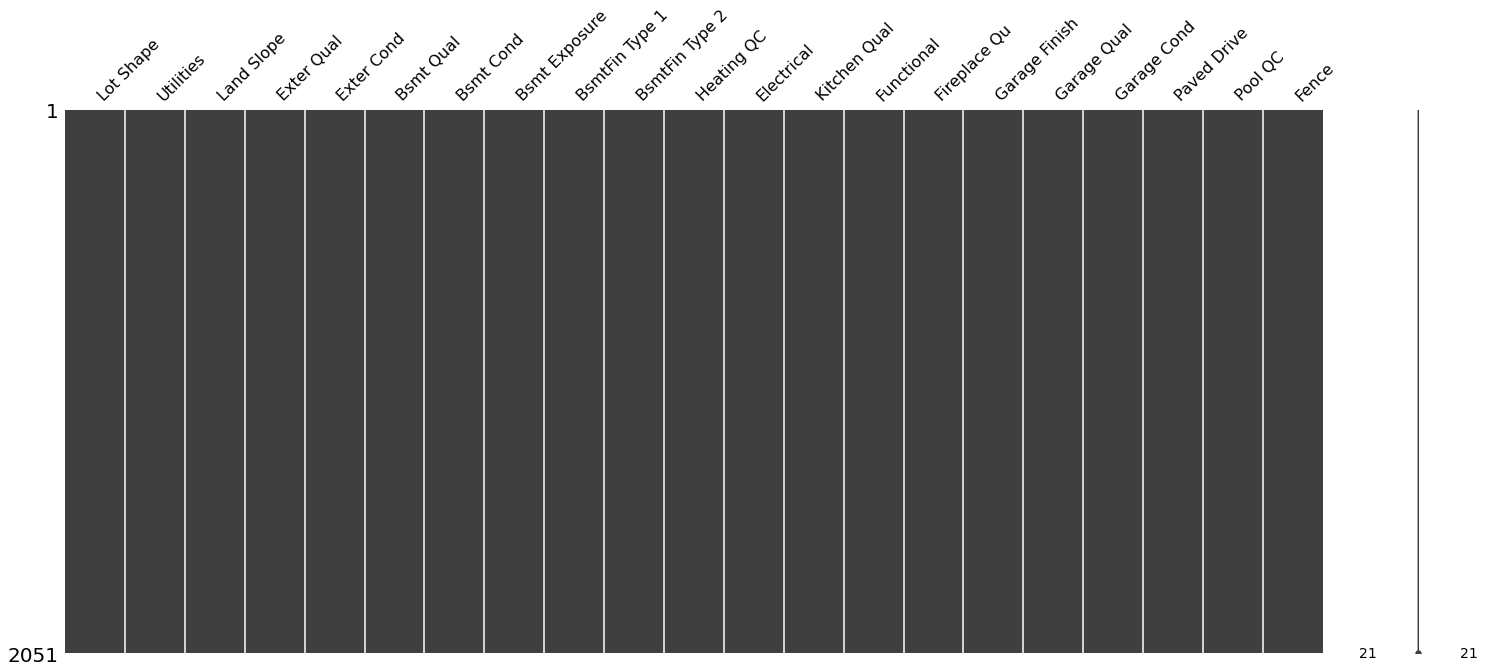

In [27]:
# Now with the ordinal rank classifications, the columns in question have no more missing data; 'NA' is treated as
# having none of that type (basement, alley, pool, etc.)
msno.matrix(train_df[ord_cat_list]);

In [28]:
# Updating feature summary with new information about null counts
feat_summ['train_null'] = train_df.isnull().sum()
feat_summ['test_null'] = test_df.isnull().sum()
feat_summ['train_null%'] = round(feat_summ['train_null']/train_df.shape[0],4) * 100
feat_summ['test_null%'] = round(feat_summ['test_null']/test_df.shape[0],4) * 100
feat_summ[feat_summ['train_null%'] > 0]

,train_df,test_df,train_null,test_null,train_null%,test_null%,train_dtype,test_dtype,ms_str,ftypes,decr
Lot Frontage,True,True,330,160.0,16.09,18.22,float64,float64,NaN,Continuous,Linear feet of street connected to property
Alley,True,True,1911,820.0,93.17,93.39,object,object,NaN,Nominal,Type of alley access to property
Mas Vnr Type,True,True,22,1.0,1.07,0.11,object,object,NaN,Nominal,Masonry veneer type
Mas Vnr Area,True,True,22,1.0,1.07,0.11,float64,float64,NaN,Continuous,Masonry veneer area in square feet
BsmtFin SF 1,True,True,1,0.0,0.05,0.00,float64,int64,NaN,Continuous,Type 1 finished square feet
BsmtFin SF 2,True,True,1,0.0,0.05,0.00,float64,int64,NaN,Continuous,Type 2 finished square feet
Bsmt Unf SF,True,True,1,0.0,0.05,0.00,float64,int64,NaN,Continuous,Unfinished square feet of basement area
Total Bsmt SF,True,True,1,0.0,0.05,0.00,float64,int64,NaN,Continuous,Total square feet of basement area
Bsmt Full Bath,True,True,2,0.0,0.10,0.00,float64,int64,NaN,Discrete,Basement full bathrooms
Bsmt Half Bath,True,True,2,0.0,0.10,0.00,float64,int64,NaN,Discrete,Basement half bathrooms


Checking the feature summary again, we notice that now there are **no more ordinal fields that have missing data** as well, and now we can turn our attention to the other columns.

As mentioned earlier, we will take the follow approach moving forward with the rest of the data:
1. imputing values for the numerical data (continuous and discrete),
2. dummifying nominal data (note will do this as and when is needed, to avoid dealing with so many columns)
3. Take note of fields with extremely high NA fields ('Alley', 'Pool QC', 'Fence', and 'Misc Feature') - these fields may not have enough data to be credible for predictions.

Note that for 2, any NaN data would be implied as the residual of all other dummy fields being 0.

### 1.4 Exporting out treated datasets

In [29]:
# Export out feature summary to csv
feat_summ.to_csv('datasets/feature_summary.csv')
train_df.to_csv('datasets/train_ord.csv') # train set with converted ordinal data
test_df.to_csv('datasets/test_ord.csv') # test set with converted ordinal data

## 2 EDA
Angles to analyse data by:
1. Checking which fields have the best direct correlation with the sales price in the train set

### 2.1 General Correlation Check with SalesPrice
First, a quick glance at the overall 'heatmap' of correlation, to pick out any patterns or 'clusters' of related features.  
Note: This heatmap does not include nominal data that has yet to be dummified.

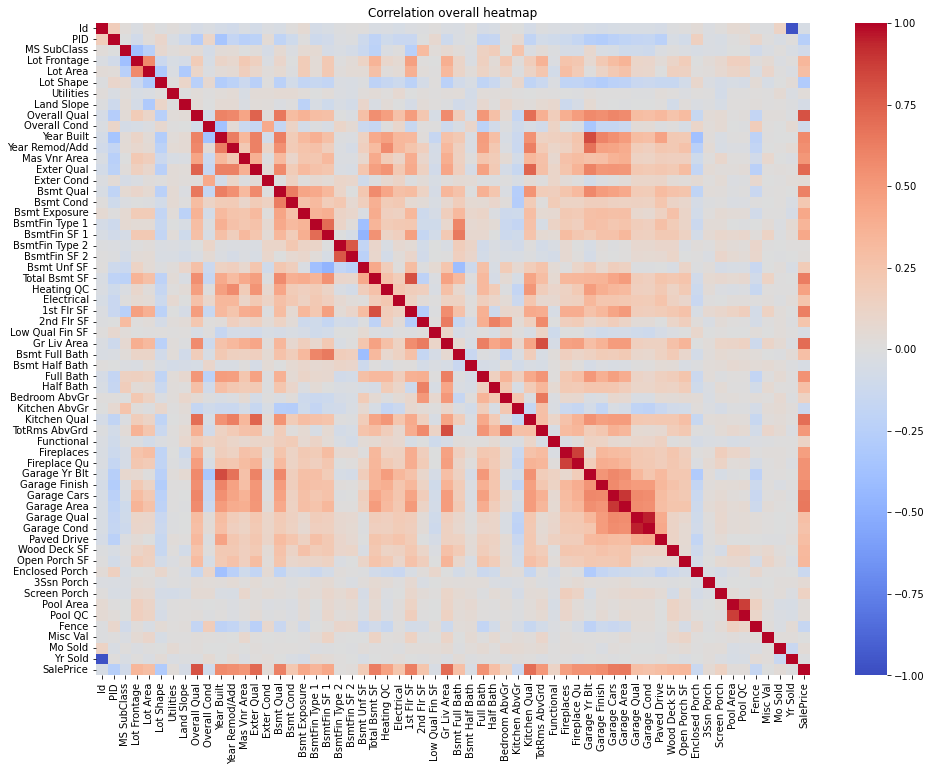

In [30]:
plt.figure(figsize = (16,12))
plt.title('Correlation overall heatmap')
sns.heatmap(train_df.corr(), cmap = 'coolwarm', vmin = -1, vmax = 1);

In [31]:
# Significantly correlated features
print(train_df.corr()[train_df.corr()['SalePrice'] > 0.5]['SalePrice'].T.shape)
train_df.corr()[train_df.corr()['SalePrice'] > 0.5]['SalePrice'].T

(18,)


Overall Qual      0.800207
Year Built        0.571849
Year Remod/Add    0.550370
Mas Vnr Area      0.512230
Exter Qual        0.712146
Bsmt Qual         0.612188
Total Bsmt SF     0.628925
1st Flr SF        0.618486
Gr Liv Area       0.697038
Full Bath         0.537969
Kitchen Qual      0.692336
TotRms AbvGrd     0.504014
Fireplace Qu      0.538925
Garage Yr Blt     0.533922
Garage Finish     0.557839
Garage Cars       0.648220
Garage Area       0.650270
SalePrice         1.000000
Name: SalePrice, dtype: float64

In [32]:
# Significantly negatively correlated features:
train_df.corr()[train_df.corr()['SalePrice'] < -0.5]['SalePrice'].T

Series([], Name: SalePrice, dtype: float64)

**Observation summary at this point:**
1. There aren't any features negatively correlated enough to be consider significant. (P < -0.5)
2. 17 features with 50% or higher correlation to SalesPrice.
3. At this scale of comparison, we do see some clusters of correlation between the features, but it is hard to make any reasonable observations about the nature of these interactions. Thus, a more granular lens is needed on these relationships.
4. In this heatmap, I found it easier to identify clusters when unmasking the mirror duplication on the top-right hand of the graph, thus I left it in.

### 2.2 Looking at highly correlated data
Zooming in to only the highly correlated data, we see how these fields relate to the SalePrice.  

In [33]:
# Dummify Nominal Data
def dummify_nom(NA,features_df,exclusion_list):
    try:
        # 1. nominal list with NAs - these will not need to drop their first column
        if NA == 'withNA':
            drop = False
            tmp = feat_summ[(feat_summ['ftypes'] == 'Nominal') & # Nominal data
                            ((feat_summ['train_null%'] == 0)&(feat_summ['test_null%'] == 0)) # No missing data
                            ].index 
        # 2. nominal list without NAs - these will need to drop their first column
        elif NA == 'withoutNA':
            drop = True
            tmp = feat_summ[(feat_summ['ftypes'] == 'Nominal') & # Nominal data
                            ((feat_summ['train_null%'] > 0)|(feat_summ['test_null%'] > 0)) # No missing data
                            ].index 

        tmp = [i for i in tmp if i not in exclusion_list]
        
        # Get dummies on nominal data, and apply it to features_df
        return pd.get_dummies(features_df, columns = tmp, drop_first = drop)
    except:
        print(f'did not perform get_dummies on nominal data')

In [34]:
# Dummify Nominal Data
train_df_dummy = train_df[:]
train_df_dummy = dummify_nom('withNA',train_df_dummy,['Id','PID'])
train_df_dummy = dummify_nom('withoutNA',train_df_dummy,['Id','PID'])

In [35]:
high_corr_list = train_df_dummy.corr()[(train_df_dummy.corr()['SalePrice'] > 0.5)|
                                       (train_df_dummy.corr()['SalePrice'] < -0.5)].index

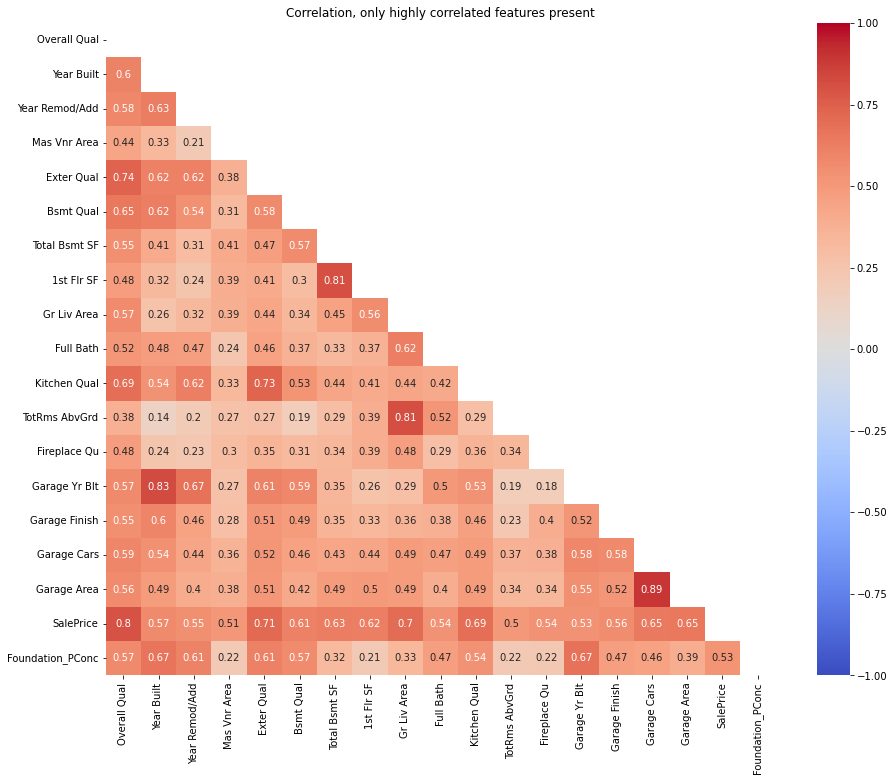

In [36]:
plt.figure(figsize = (15,12))
plt.title('Correlation, only highly correlated features present')
corr = train_df_dummy[high_corr_list].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(train_df_dummy[high_corr_list].corr(),
            vmin = -1,
            vmax = 1,
            cmap = 'coolwarm',
            annot = True,
            mask = mask);

From the graph above, we notice a few perhaps alarming things about this set. Firstly, alot of the features that are highly correlated with the SalePrice are also heavily correlated with each other. To illustrate this:

In [43]:
pd.DataFrame((train_df_dummy[high_corr_list].corr().sum() - 1)/len(train_df_dummy[high_corr_list].columns), 
             columns = ['Average Corr']).T

,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,Exter Qual,Bsmt Qual,Total Bsmt SF,1st Flr SF,Gr Liv Area,Full Bath,Kitchen Qual,TotRms AbvGrd,Fireplace Qu,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,SalePrice,Foundation_PConc
Average Corr,0.543865,0.467536,0.427024,0.317491,0.502511,0.444306,0.418159,0.391567,0.438503,0.411993,0.473232,0.313254,0.32516,0.45759,0.423905,0.480801,0.464122,0.573473,0.42501


### 2.3 Grouping data into related sets and looking at correlations
From the graph in 2.1, we notice that there seems to be some clustering of correlations amongst some of the fields.  
[PLACEHOLDER]

### 2.4 Market Segmentation, and Prediction Performance
As will be elaborated further in the modeling section of this project, in economics oftentimes market segments behave differently with varying social, political, geographic, or economic conditions (net worth, for example).

In this section, we will explore which of the categorical data present in the Ames Housing dataset can be used as a proxy for separating these market segments. They must fulfill a couple of criteria, namely:

1. The segments must be distinct enough to have a statistically significant difference, and;
2. There must be enough data in each segment to properly train the model.

With these in mind, we are looking for segmentations of perhaps 2-3 distinct groups within a specific feature, with a roughly even (perhaps 40-60% would be acceptable) difference in data volume between them.

In [64]:
train_df_unique = pd.DataFrame([len(train_df[i].unique()) for i in train_df.columns], 
                               index = train_df.columns, columns = ['unique'])

train_df_unique[train_df_unique['unique'] < 10].T

,MS Zoning,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Condition 1,Condition 2,...,Garage Finish,Garage Cars,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence,Misc Feature,Yr Sold,Sale Type
unique,7,2,3,4,4,3,5,3,9,8,...,4,7,6,6,3,5,5,6,5,9


#### 2.4.1 Lot Shape
Looking at the dataset within the context of Lot Shape:
1. Lot shape 0 (corresponding to most irregular lot) has too little count
2. Since Lot shapes 0, 1, and 2 are mostly referring to varying degrees of irregularity, we can simplify lot shape into two main categories: regular and irregular.

In [108]:
train_df.groupby(['Lot Shape'])['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
Lot Shape,,,,,,,,
0,9.0,193182.222222,58500.737982,73000.0,163500.0,192140.0,220000.0,267000.0
1,55.0,233954.745455,89824.066055,109000.0,174000.0,217500.0,247700.0,538000.0
2,692.0,211848.670520,83359.764142,52000.0,157000.0,190000.0,250000.0,611657.0
3,1295.0,162925.812355,70198.139114,12789.0,120000.0,145000.0,185492.5,582933.0


In [113]:
# Grouping Lot Shape by regular/irregular
train_df_ltshp = train_df[:]
train_df_ltshp['Lot Shape'] = [1 if i == 3 else 0 for i in train_df['Lot Shape']]
train_df_ltshp.groupby('Lot Shape')['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
Lot Shape,,,,,,,,
0,756.0,213234.697090,83731.570034,52000.0,158000.0,191000.0,250000.0,611657.0
1,1295.0,162925.812355,70198.139114,12789.0,120000.0,145000.0,185492.5,582933.0


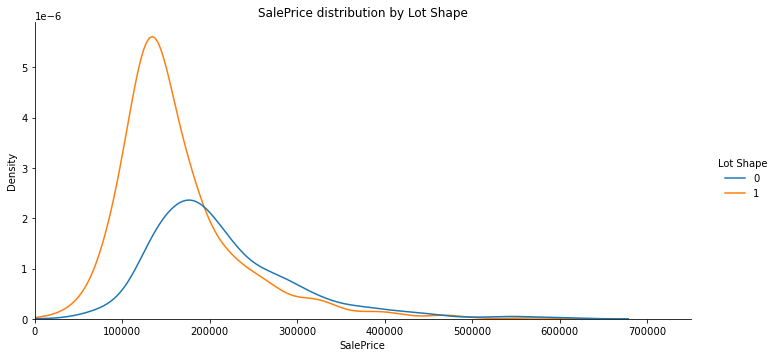

In [181]:
sns.displot(train_df_ltshp[['Lot Shape','SalePrice']], 
            x = 'SalePrice', hue = 'Lot Shape', kind = 'kde', aspect = 2)
plt.title('SalePrice distribution by Lot Shape')
plt.xlim(0,750000);

Some observations:
1. There is more available data for regular lot shapes than irregular
2. The variance of data for Lot Shape = 1 is also lower

Lot Shape = 1 (Regular lots) will likely be a better estimator of sale price than lot shape = 0. 

#### 2.4.2 Utilities
While Utilities looked like a promising separator, it is immediately clear at first glance that it would not be good for the role, as there are only 2 properties that fall under categories 1 and 2, which are less than full utility coverage.

In [172]:
train_df.groupby('Utilities')['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
Utilities,,,,,,,,
1,1.0,137500.000000,NaN,137500.0,137500.0,137500.0,137500.0,137500.0
2,1.0,57625.000000,NaN,57625.0,57625.0,57625.0,57625.0,57625.0
3,2049.0,181551.602245,79244.116778,12789.0,129850.0,162500.0,214000.0,611657.0


#### 2.4.3 Overall Quality
From earlier, we know that Overall Quality is one of the more correlated features in the Ames Dataset to Sales Price. Taking this a step further, we will look into the relationship of the quality rate, and whether the SalePrice varies by segmentation.

In [174]:
train_df.groupby('Overall Qual')['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
Overall Qual,,,,,,,,
1,4.0,48725.000000,29341.935292,13100.0,32750.0,50150.0,66125.00,81500.0
2,9.0,51081.000000,21044.635997,12789.0,35311.0,57625.0,63900.00,82000.0
3,29.0,81309.103448,23905.920174,37900.0,64500.0,81400.0,93500.00,139600.0
4,159.0,107744.037736,30799.878602,34900.0,86950.0,106500.0,125500.00,256000.0
5,563.0,134963.644760,26631.294740,55993.0,120000.0,133500.0,148000.00,284700.0
6,506.0,162891.102767,38643.606137,79000.0,137462.5,160000.0,183425.00,415000.0
7,431.0,203430.285383,42722.280426,105000.0,175950.0,197900.0,226250.00,383970.0
8,250.0,271437.044000,62023.449524,122000.0,230000.0,267150.0,305369.25,538000.0
9,77.0,370197.376623,84457.638065,150000.0,319900.0,359900.0,410000.00,611657.0


In [258]:
# In order to maintain some density in the numbers, lets re-rank the data into the following buckets:
# 1) rank 0 [1-4]
# 2) rank 1 [5-7]
# 3) rank 2 [8-10]

train_df_OQ = train_df_dummy[:]
train_df_OQ['Overall Qual'] = [2 if i > 7 else 0 if i < 5 else 1 for i in train_df_OQ['Overall Qual']]
train_df_OQ.groupby('Overall Qual')['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
Overall Qual,,,,,,,,
0,201.0,100218.383085,33445.666813,12789.0,81400.0,99500.0,120500.00,256000.0
1,1500.0,164057.255333,45350.411864,55993.0,131187.5,156000.0,189000.00,415000.0
2,350.0,302755.942857,86989.458586,122000.0,248225.0,288545.0,344783.25,611657.0


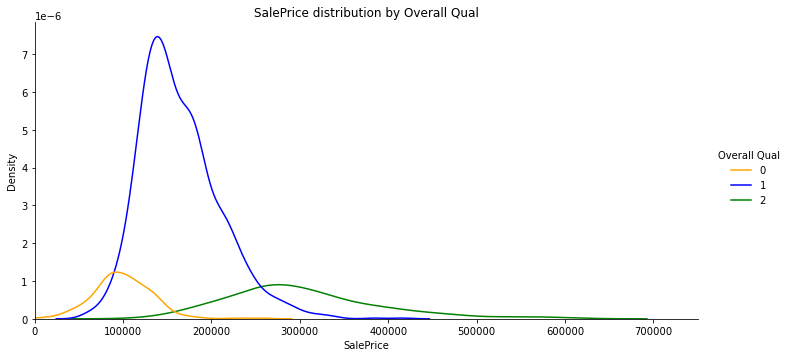

In [259]:
sns.displot(train_df_OQ[['Overall Qual','SalePrice']], 
            x = 'SalePrice', hue = 'Overall Qual', kind = 'kde', 
            aspect = 2, palette = ['orange','blue','green'])
plt.title('SalePrice distribution by Overall Qual')
plt.xlim(0,750000);

Rather obviously, the above information informs us about a few things:
1. There is definitely a significant divergence in the relationship of each bucket from the others.
2. The middle bucket has the bulk of the data.

Tweaking the buckets slightly (Rank 0: 1-5, Rank 1: 6-7, Rank 2: 8-10), we get the following:

In [261]:
# 1) rank 0 [1-5]
# 2) rank 1 [6-7]
# 3) rank 2 [8-10]

train_df_OQ2 = train_df_dummy[:]
train_df_OQ2['Overall Qual'] = [2 if i > 7 else 0 if i < 6 else 1 for i in train_df_OQ2['Overall Qual']]
train_df_OQ2.groupby('Overall Qual')['SalePrice'].describe()

,count,mean,std,min,25%,50%,75%,max
Overall Qual,,,,,,,,
0,764.0,125822.548429,32403.132527,12789.0,108000.0,128500.0,144000.00,284700.0
1,937.0,181538.261473,45308.413845,79000.0,149500.0,177500.0,208000.00,415000.0
2,350.0,302755.942857,86989.458586,122000.0,248225.0,288545.0,344783.25,611657.0


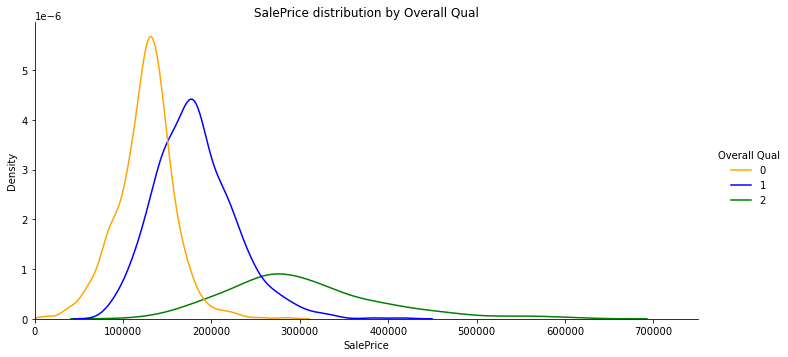

In [285]:
sns.displot(train_df_OQ2[['Overall Qual','SalePrice']], 
            x = 'SalePrice', hue = 'Overall Qual', kind = 'kde', 
            aspect = 2, palette = ['orange','blue','green'])
plt.title('SalePrice distribution by Overall Qual')
plt.xlim(0,750000);

Adjusting the buckets to band 1-5 in bucket [0], 6-7 in bucket [1], and 8-10 in bucket[2], we get a more robust differentiation for the 3 subsets. We will look at the impact of this group in the regression analysis later.

One more aspect to look at is how the correlated features to SalePrice change in each subset.

In [287]:
# List of top 10 correlated features for each of the subsets, Overall Qual buckets 0,1,2.

OQ2_Summ = pd.DataFrame(index = range(0,11))
for i in [0,1,2]:
    OQ2_tmp = pd.DataFrame(train_df_OQ2[train_df_OQ2['Overall Qual'] == i].corr()['SalePrice'])
    OQ2_tmp = OQ2_tmp.sort_values('SalePrice', ascending = False).head(11).reset_index()
    OQ2_tmp.columns = ['OQ'+str(i),'OQ'+str(i)+'_corr']
    OQ2_Summ[OQ2_tmp.columns] = OQ2_tmp

OQ2_Summ.loc[1:,:]

,OQ0,OQ0_corr,OQ1,OQ1_corr,OQ2,OQ2_corr
1,1st Flr SF,0.516779,Gr Liv Area,0.658482,Kitchen Qual,0.517902
2,Gr Liv Area,0.487283,Garage Area,0.541589,Gr Liv Area,0.513535
3,Total Bsmt SF,0.465055,Garage Cars,0.526667,Garage Cars,0.512368
4,Central Air_Y,0.439907,Full Bath,0.502532,TotRms AbvGrd,0.501728
5,BsmtFin SF 1,0.437947,1st Flr SF,0.499822,Exter Qual,0.501463
6,Paved Drive,0.410663,Total Bsmt SF,0.492332,Mas Vnr Area,0.496856
7,Year Built,0.408489,TotRms AbvGrd,0.440296,Bsmt Qual,0.495505
8,BsmtFin Type 1,0.402716,Kitchen Qual,0.431487,Garage Area,0.490732
9,Fireplaces,0.390328,Exter Qual,0.420268,Fireplace Qu,0.432934
10,Garage Area,0.385854,Year Remod/Add,0.407365,1st Flr SF,0.410804


The top 10 correlated features for each subset varies wildly. This may be an indication that the things that influence a property purchase may vary based on the price; for example, Garage Cars (the number of) is a bigger indicator of purchase for buckets 1 and 2, while is not present for 0.


In [284]:
# Getting list of top 20 correlated features for 3.3.3 in regression analysis
No_corr_features = 20
OQ2_corr_list = pd.DataFrame(index = range(0,No_corr_features+1))
for i in [0,1,2]:
    OQ2_tmp = pd.DataFrame(train_df_OQ2[train_df_OQ2['Overall Qual'] == i].corr()['SalePrice'])
    OQ2_tmp = OQ2_tmp.sort_values('SalePrice', ascending = False).head(No_corr_features+1).reset_index()
    OQ2_tmp.columns = ['OQ'+str(i),'OQ'+str(i)+'_corr']
    OQ2_corr_list[OQ2_tmp.columns] = OQ2_tmp
    OQ2_corr_list.drop(columns = ['OQ'+str(i)+'_corr'], inplace = True)

OQ2_corr_list.drop(index = 0).to_csv('datasets/3_3_3_corrlist.csv')